# Reusable Embeddings

**Learning Objectives**
* Learn how to use Tensorflow Hub pre-trained text modules for building text ML models
* Get familiar with two popular TF Hub modules for text: nnlm and Swivel


## Introduction


In this notebook, we will implement text models to recognize the probable source (Github, Tech-Crunch, or The New-York Times) of the titles we have in the title dataset we constructed in a previous lab.

First, we will load and pre-process the texts and labels so that they are suitable to be fed to sequential Keras models with first layer being TF-hub pre-trained modules. Thanks to this first layer, we won't need to tokenize and integerize the text before passing it to our models. The pre-trained layer will take care of that for us, and consume directly raw text. However, we will still have to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will build, train and compare simple DNN models starting with different pre-trained TF-Hub layers.

In [ ]:
# Ensure that we have the right version of Tensorflow installed.
!pip freeze | grep tf-nightly-2.0-preview || pip install tf-nightly-2.0-preview

In [2]:
import datetime
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow_hub import KerasLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2.0.0-dev20190925


In [3]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [4]:
MODEL_DIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

As in the previous labs, our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, Tech-Crunch, or the New-York Times):

In [5]:
ls ./data/

titles_full.csv    titles_sample.csv


In [6]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,show hn macosx preferences pane for mongodb,github
1,yacc is dead parsing with derivatives implem...,github
2,the truth about the wars,nytimes
3,the lottery mentality,nytimes
4,dagobah v0.3.0 released dag-based job schedu...,github


Let's look again at the number of examples per label to make sure we have a well-balanced dataset:

In [7]:
titles_df.source.value_counts()

github        36525
techcrunch    30891
nytimes       28787
Name: source, dtype: int64

## Preparing the labels

In this lab, we will use pre-trained [TF-Hub embeddings modules for english](https://tfhub.dev/s?q=tf2%20embeddings%20text%20english) for the first layer of our models. One immediate
advantage of doing so is that the TF-Hub embedding module will take care for us of processing the raw text. 
This also means that our model will be able to consume text directly instead of sequences of integers representing the words.

However, as before, we still need to preprocess the labels into one-hot-encoded vectors:

In [8]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [9]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes, num_classes=N_CLASSES)
    return one_hots

In [10]:
encode_labels(titles_df.source[:4])

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

## Preparing the train/test splits

Let's split our data into train and test splits:

In [12]:
N_TRAIN = int(len(titles_df) * 0.95)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per class.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.

In [13]:
sources_train.value_counts()

github        34722
techcrunch    29283
nytimes       27387
Name: source, dtype: int64

In [14]:
sources_valid.value_counts()

github        1803
techcrunch    1608
nytimes       1400
Name: source, dtype: int64

Now let's create the features and labels we will feed our models with:

In [15]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [16]:
X_train[:3]

array(['show hn  macosx preferences pane for mongodb',
       'yacc is dead  parsing with derivatives  implemented in go',
       'the truth about the wars'], dtype=object)

In [17]:
Y_train[:3]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

## NNLM Model

We will first try a word embedding pre-trained using a [Neural Probabilistic Language Model](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). TF-Hub has a 50-dimensional one called 
[nnlm-en-dim50-with-normalization](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1), which also
normalizes the vectors produced. 

Once loaded from its url, the TF-hub module can be used as a normal Keras layer in a sequential or functional model. Since we have enough data to fine-tune the parameters of the pre-trained embedding itself, we will set `trainable=True` in the `KerasLayer` that loads the pre-trained embedding:

In [18]:
NNLM = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"

nnlm_module = KerasLayer(
    NNLM, output_shape=[50], input_shape=[], dtype=tf.string, trainable=True)

Note that this TF-Hub embedding produces a single 50-dimensional vector when passed a sentence:

In [19]:
nnlm_module(tf.constant(["The dog is happy to see people in the street."]))

<tf.Tensor: id=184, shape=(1, 50), dtype=float32, numpy=
array([[ 0.1299611 ,  0.08171072,  0.06024609,  0.1897307 ,  0.1554303 ,
         0.02832681,  0.20851292, -0.20073421, -0.1162339 ,  0.09962303,
        -0.00823456,  0.07382201, -0.151453  , -0.03049451, -0.09065688,
        -0.4422915 , -0.00984869, -0.05030105,  0.0120667 , -0.3166044 ,
        -0.10787552, -0.23041075,  0.08485214,  0.04026556,  0.09290276,
         0.26631656, -0.33125097, -0.06418459, -0.00408724, -0.01634568,
        -0.20365101, -0.05161688,  0.08445277,  0.02203171, -0.37011603,
        -0.24225973,  0.0447066 , -0.05840004, -0.02355968, -0.0995158 ,
        -0.01159552,  0.01638035, -0.09878304,  0.06675767, -0.00144666,
         0.00651569,  0.0162654 , -0.09303603, -0.0172936 ,  0.08206343]],
      dtype=float32)>

## Swivel Model

Then we will try a word embedding obtained using [Swivel](https://arxiv.org/abs/1602.02215), an algorithm that essentially factorizes word co-occurrence matrices to create the words embeddings. 
TF-Hub hosts the pretrained [gnews-swivel-20dim-with-oov](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) 20-dimensional Swivel module.

In [20]:
SWIVEL = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
swivel_module = KerasLayer(
    SWIVEL, output_shape=[20], input_shape=[], dtype=tf.string, trainable=True)

Similarly as the previous pre-trained embedding, it outputs a single vector when passed a sentence:

In [21]:
swivel_module(tf.constant(["The dog is happy to see people in the street."]))

<tf.Tensor: id=363, shape=(1, 20), dtype=float32, numpy=
array([[ 0.9967701 , -0.3100155 ,  0.5889897 , -0.16765082, -0.6171738 ,
        -1.1586996 , -0.8619045 ,  0.7281645 ,  0.32575002,  0.4754492 ,
        -0.9272241 ,  0.41090095, -0.75389475, -0.31525993, -1.8918804 ,
         0.6423996 ,  0.6801622 , -0.1335669 , -1.0017993 , -0.11908641]],
      dtype=float32)>

## Building the models

Let's write a function that 

* takes as input an instance of a `KerasLayer` (i.e. the `swivel_module` or the `nnlm_module` we constructed above) as well as the name of the model (say `swivel` or `nnlm`)
* returns a compiled Keras sequential model starting with this pre-trained TF-hub layer, adding one or more dense relu layers to it, and ending with a softmax layer giving the probability of each of the classes:

In [22]:
def build_model(hub_module, name):
    model = Sequential([
        hub_module,
        Dense(16, activation='relu'),
        Dense(N_CLASSES, activation='softmax')
    ], name=name)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's also wrap the training code into a `train_and_evaluate` function that 
* takes as input the training and validation data, as well as the compiled model itself, and the `batch_size`
* trains the compiled model for 100 epochs at most, and does early-stopping when the validation loss is no longer decreasing
* returns an `history` object, which will help us to plot the learning curves

In [23]:
def train_and_evaluate(train_data, val_data, model, batch_size=5000):
    X_train, Y_train = train_data

    tf.random.set_seed(33)

    model_dir = os.path.join(MODEL_DIR, model.name)
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)

    history = model.fit(
        X_train, Y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=val_data,
        callbacks=[EarlyStopping(), TensorBoard(model_dir)],
    )
    return history

## Training NNLM

In [24]:
data = (X_train, Y_train)
val_data = (X_valid, Y_valid)

In [26]:
nnlm_model = build_model(nnlm_module, 'nnlm')
nnlm_history = train_and_evaluate(data, val_data, nnlm_model)

Train on 91392 samples, validate on 4811 samples
Epoch 1/100
91392/91392 [==============================] - 14s 148us/sample - loss: 1.0341 - accuracy: 0.5461 - val_loss: 0.9673 - val_accuracy: 0.6446
Epoch 2/100
91392/91392 [==============================] - 13s 141us/sample - loss: 0.8909 - accuracy: 0.7127 - val_loss: 0.8137 - val_accuracy: 0.7381
Epoch 3/100
91392/91392 [==============================] - 12s 134us/sample - loss: 0.7213 - accuracy: 0.7831 - val_loss: 0.6524 - val_accuracy: 0.7853
Epoch 4/100
91392/91392 [==============================] - 13s 137us/sample - loss: 0.5699 - accuracy: 0.8179 - val_loss: 0.5355 - val_accuracy: 0.8059
Epoch 5/100
91392/91392 [==============================] - 13s 143us/sample - loss: 0.4659 - accuracy: 0.8403 - val_loss: 0.4643 - val_accuracy: 0.8192
Epoch 6/100
91392/91392 [==============================] - 13s 142us/sample - loss: 0.3992 - accuracy: 0.8571 - val_loss: 0.4218 - val_accuracy: 0.8341
Epoch 7/100
91392/91392 [==============

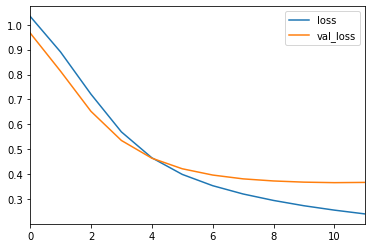

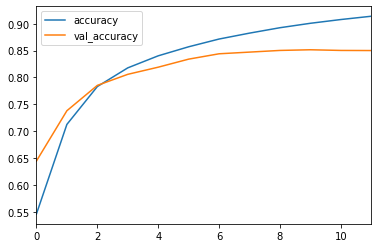

In [27]:
history = nnlm_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

## Training Swivel

In [29]:
swivel_model = build_model(swivel_module, name='swivel')

In [31]:
swivel_history = train_and_evaluate(data, val_data, swivel_model)

Train on 91392 samples, validate on 4811 samples
Epoch 1/100
91392/91392 [==============================] - 1s 9us/sample - loss: 1.1823 - accuracy: 0.3465 - val_loss: 1.1105 - val_accuracy: 0.4003
Epoch 2/100
91392/91392 [==============================] - 0s 5us/sample - loss: 1.0604 - accuracy: 0.4483 - val_loss: 1.0210 - val_accuracy: 0.4922
Epoch 3/100
91392/91392 [==============================] - 0s 5us/sample - loss: 0.9860 - accuracy: 0.5234 - val_loss: 0.9584 - val_accuracy: 0.5506
Epoch 4/100
91392/91392 [==============================] - 0s 5us/sample - loss: 0.9284 - accuracy: 0.5705 - val_loss: 0.9052 - val_accuracy: 0.5905
Epoch 5/100
91392/91392 [==============================] - 0s 5us/sample - loss: 0.8759 - accuracy: 0.6090 - val_loss: 0.8544 - val_accuracy: 0.6200
Epoch 6/100
91392/91392 [==============================] - 0s 5us/sample - loss: 0.8238 - accuracy: 0.6417 - val_loss: 0.8036 - val_accuracy: 0.6487
Epoch 7/100
91392/91392 [==============================] 

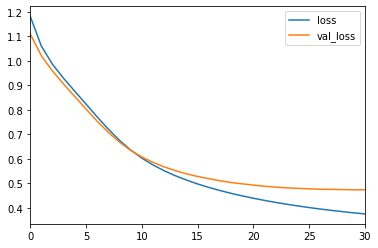

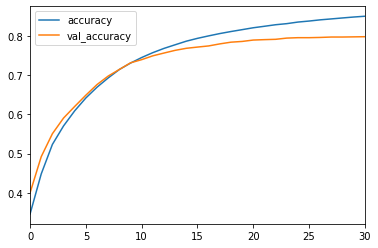

In [32]:
history = swivel_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

## Comparing the models

Swivel trains faster but achieves a lower validation accuracy, and requires more epochs to train on.

At last, let's compare all the models we have trained at once using TensorBoard in order
to choose the one that overfits the less for the same performance level.

Running the following command will launch TensorBoard on port 6006. This will
block the notebook execution, so you'll have to interrupt that cell first before
you can run other cells.


In [ ]:
!tensorboard --logdir $MODEL_DIR --port 6006

## Bonus

Try to beat the best model by modifying the model architecture, changing the TF-Hub embedding, and tweaking the training parameters.

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License